In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms 
import sklearn
import sklearn.metrics as metrics
import numpy as np

import pandas as pd
from torch.utils.data import Dataset
import os 
from PIL import Image

In [2]:
class CUB (Dataset):
    '''
    parts 
        part_locs 
        parts 
    images 
        200 classes
    classes.txt
    train_test_split.txt
    image_class_labels.txt
    
    '''
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir # D:\TorchProject\dataset\cub\CUB_200_2011
        self.transform = transform
        self.image_dir = os.path.join(root_dir,'images')
        self.image_mapping = self._load_image_mapping()
        self.label_mapping = self._load_label_mapping()
        self.part_locs_mapping = self._load_part_locs_mapping()
        self.part_names = self._load_part_name_mapping()

    def _load_part_name_mapping (self):
        part_names= {}
        part_names = os.path.join(self.root_dir, 'parts', 'parts.txt')
        with open(part_names, 'r') as file:
            for line in file:
                part_id, name = line.strip().split()
                if part_id not in part_names:
                    part_names [part_id] = {}
                part_names[part_id] = part_names
        return part_names

    def _load_part_locs_mapping (self):
        part_locs_mapping = {}
        part_locs = os.path.join(self.root_dir, 'parts', 'part_locs.txt')
        with open(part_locs, 'r') as file:
            for line in file:
                image_id, part_id, x, y, visible = line.strip().split()
                if image_id not in part_locs_mapping:
                    part_locs_mapping[image_id] = {}
                part_locs_mapping[image_id][part_id] = [float (x), float (y)]
        return part_locs_mapping

    def _load_label_mapping (self):
        label_mapping = {}
        label_file = os.path.join(self.root_dir,'image_class_labels.txt')
        with open(label_file, 'r') as file:
            for line in file:
                image_id, label_id = line.strip().split()
                label_mapping[image_id] = int(label_id)
        return label_mapping

    def _load_image_mapping (self):
        image_mapping = {}
        image_file = os.path.join(self.root_dir,'images.txt')
        with open(image_file, 'r') as file:
            for line in file:
                image_id, image_name = line.strip().split()
                image_mapping[image_id] = image_name
        return image_mapping

    def __len__(self):
        return len(self.image_mapping)

    def __getitem__(self, index):
        label = self.label_mapping[str(index+1)]
        part_locs = self.part_locs_mapping.get(str(index), [])
        image_name = self.image_mapping[str(index)]
        print(image_name)

        image= Image.open(os.path.join(self.image_dir,image_name)).convert('RGB')

        if self.transform:
           image = self.transform(image)
        return (image, label, part_locs)

11788
001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg
1 {'1': [0.0, 0.0], '2': [312.0, 182.0], '3': [0.0, 0.0], '4': [0.0, 0.0], '5': [186.0, 45.0], '6': [247.0, 79.0], '7': [0.0, 0.0], '8': [0.0, 0.0], '9': [0.0, 0.0], '10': [100.0, 221.0], '11': [183.0, 101.0], '12': [0.0, 0.0], '13': [0.0, 0.0], '14': [0.0, 0.0], '15': [215.0, 194.0]}


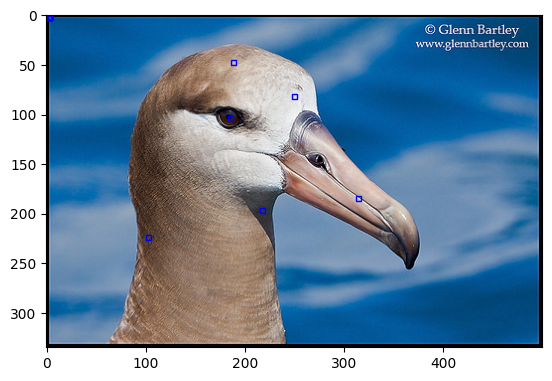

001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg
1 {'1': [228.0, 138.0], '2': [282.0, 154.0], '3': [0.0, 0.0], '4': [248.0, 158.0], '5': [266.0, 141.0], '6': [272.0, 144.0], '7': [0.0, 0.0], '8': [0.0, 0.0], '9': [208.0, 102.0], '10': [256.0, 141.0], '11': [270.0, 146.0], '12': [0.0, 0.0], '13': [234.0, 193.0], '14': [163.0, 155.0], '15': [260.0, 155.0]}


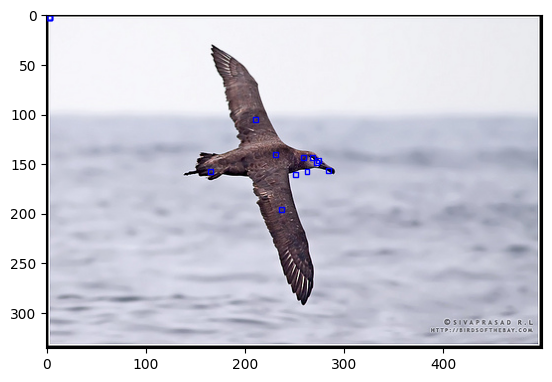

001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg
1 {'1': [227.0, 213.0], '2': [376.0, 160.0], '3': [0.0, 0.0], '4': [325.0, 243.0], '5': [324.0, 121.0], '6': [349.0, 128.0], '7': [0.0, 0.0], '8': [0.0, 0.0], '9': [170.0, 198.0], '10': [288.0, 169.0], '11': [336.0, 136.0], '12': [0.0, 0.0], '13': [199.0, 237.0], '14': [42.0, 201.0], '15': [327.0, 174.0]}


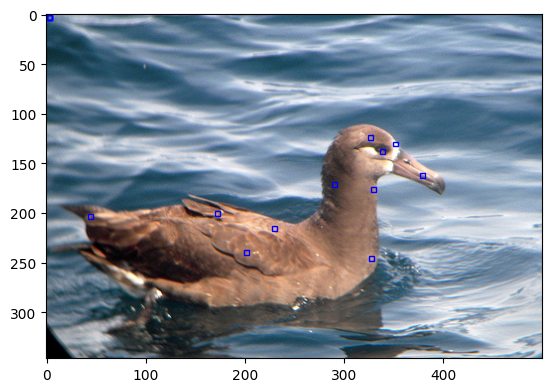

001.Black_footed_Albatross/Black_Footed_Albatross_0074_59.jpg
1 {'1': [221.0, 179.0], '2': [126.0, 203.0], '3': [0.0, 0.0], '4': [190.0, 215.0], '5': [157.0, 180.0], '6': [145.0, 187.0], '7': [153.0, 189.0], '8': [0.0, 0.0], '9': [238.0, 245.0], '10': [182.0, 183.0], '11': [0.0, 0.0], '12': [0.0, 0.0], '13': [235.0, 133.0], '14': [337.0, 211.0], '15': [174.0, 207.0]}


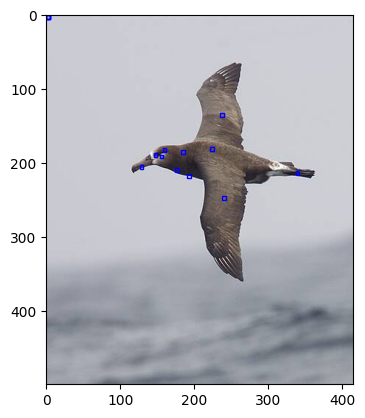

001.Black_footed_Albatross/Black_Footed_Albatross_0014_89.jpg
1 {'1': [0.0, 0.0], '2': [194.0, 147.0], '3': [132.0, 159.0], '4': [154.0, 153.0], '5': [177.0, 137.0], '6': [183.0, 139.0], '7': [0.0, 0.0], '8': [0.0, 0.0], '9': [137.0, 203.0], '10': [166.0, 137.0], '11': [179.0, 141.0], '12': [0.0, 0.0], '13': [138.0, 107.0], '14': [76.0, 160.0], '15': [175.0, 150.0]}


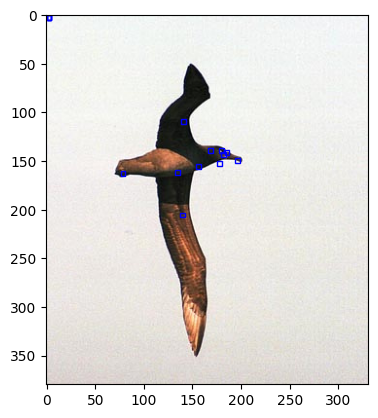

001.Black_footed_Albatross/Black_Footed_Albatross_0085_92.jpg
1 {'1': [163.0, 180.0], '2': [264.0, 202.0], '3': [0.0, 0.0], '4': [190.0, 213.0], '5': [240.0, 181.0], '6': [253.0, 187.0], '7': [0.0, 0.0], '8': [57.0, 190.0], '9': [193.0, 108.0], '10': [221.0, 181.0], '11': [244.0, 189.0], '12': [78.0, 226.0], '13': [126.0, 267.0], '14': [82.0, 199.0], '15': [228.0, 204.0]}


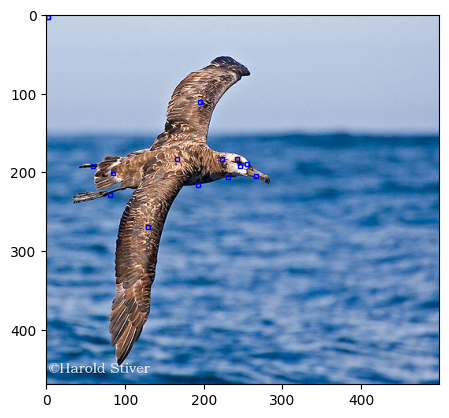

001.Black_footed_Albatross/Black_Footed_Albatross_0031_100.jpg
1 {'1': [0.0, 0.0], '2': [362.0, 243.0], '3': [0.0, 0.0], '4': [0.0, 0.0], '5': [212.0, 94.0], '6': [290.0, 133.0], '7': [0.0, 0.0], '8': [0.0, 0.0], '9': [0.0, 0.0], '10': [116.0, 229.0], '11': [240.0, 152.0], '12': [0.0, 0.0], '13': [0.0, 0.0], '14': [0.0, 0.0], '15': [251.0, 234.0]}


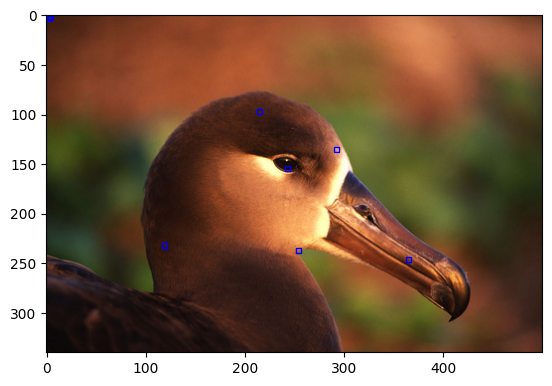

001.Black_footed_Albatross/Black_Footed_Albatross_0051_796103.jpg
1 {'1': [225.0, 162.0], '2': [107.0, 132.0], '3': [0.0, 0.0], '4': [151.0, 194.0], '5': [142.0, 96.0], '6': [120.0, 108.0], '7': [136.0, 111.0], '8': [0.0, 0.0], '9': [246.0, 186.0], '10': [175.0, 135.0], '11': [0.0, 0.0], '12': [0.0, 0.0], '13': [0.0, 0.0], '14': [388.0, 151.0], '15': [145.0, 139.0]}


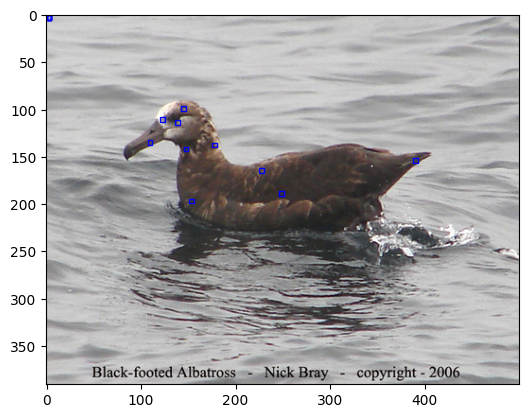

001.Black_footed_Albatross/Black_Footed_Albatross_0010_796097.jpg
1 {'1': [197.0, 136.0], '2': [129.0, 154.0], '3': [0.0, 0.0], '4': [182.0, 164.0], '5': [150.0, 137.0], '6': [140.0, 143.0], '7': [146.0, 145.0], '8': [0.0, 0.0], '9': [215.0, 189.0], '10': [169.0, 139.0], '11': [0.0, 0.0], '12': [0.0, 0.0], '13': [228.0, 112.0], '14': [298.0, 172.0], '15': [153.0, 158.0]}


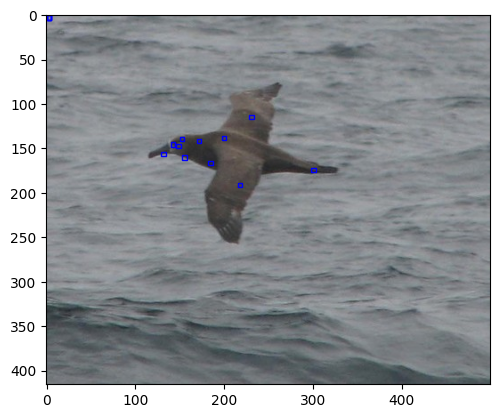

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import DataLoader
import os

def visualize_bounding_box(image, part_locs):
        # Create figure and axes
        fig, ax = plt.subplots(1)

        # Display the image
        ax.imshow(image)

    # Extract bounding box coordinates
        locs  = part_locs

        # Iterate over part bounding boxes and draw rectangles
        for part_id, part_bb in part_locs.items():
            x_pb, y_pb = part_bb
            width_pb, height_pb = 5, 5  # Modify the width and height as per your requirement

            rect_pb = patches.Rectangle((x_pb, y_pb), width_pb, height_pb, linewidth=1, edgecolor='b', facecolor='none')

            ax.add_patch(rect_pb)

            # Show the plot
        plt.show()


# Example usage

root_dir = 'D:\TorchProject\dataset\cub\CUB_200_2011'
# run dataser == __init__
dataset = CUB(root_dir) # --> load sample to check
dataloader = DataLoader(dataset, batch_size=2, shuffle=False) #divide dataset by batch

# call len  == __len__
print (len(dataset))

for i in range (1,10):
    image,label,part_locs = dataset[i]

    print (label,part_locs)

    # Visualize all bounding boxes
    visualize_bounding_box(image, part_locs)

In [16]:
### Graph construction
import networkx as nx
import torch
import random

class Graph_construct:
    def __init__(self):
        self.graph = nx.Graph()
  

    def add_nodes(self, part_locs):
        # Add nodes from 1st to 15th with their attributes
        for i in range(1, 16):
            x, y = part_locs[str(i)] # Replace with actual position (x, y) data if available
            title = f"Node {i}"
            image_tensor = torch.rand(16, 16)  # Replace with actual image tensor data if available

            node_attributes = {
                "x": x,
                "y": y,
                "title": title,
                "image": image_tensor ## wait for ViT to split
            }

            self.graph.add_node(i, **node_attributes)

        # Add nodes from 16th to the rest with their class_name attribute
        num_classes = 200  # Replace with the actual number of classes in the dataset
        for i in range(16, 216):
            class_name = f"Class {i - 15}"
            node_attributes = {"class_name": class_name}
            self.graph.add_node(i, **node_attributes)

    def calculate_edges(self):
        # Calculate edges for nodes from 1st to 15th based on distance between (x, y) positions
        for i in range(1, 16):
            for j in range(i + 1, 16):
                x1, y1 = self.graph.nodes[i]["x"], self.graph.nodes[i]["y"]
                x2, y2 = self.graph.nodes[j]["x"], self.graph.nodes[j]["y"]
                distance = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
                self.graph.add_edge(i, j, weight=distance)

        # Set edges from nodes 16th to the rest to others nodes = 1 for the initial step
        for i in range(16, 216):
            for j in range(1, 16):
                self.graph.add_edge(i, j, weight=1)

if __name__ == "__main__":
    root_dir = 'D:\TorchProject\dataset\cub\CUB_200_2011'
    # run dataser == __init__
    dataset = CUB(root_dir)
    
    graph_construct = Graph_construct()

    graph_construct.add_nodes(dataset[2][2]) # dataset -> image, label, part_locs, 
    graph_construct.calculate_edges()

    # You can access the graph object with all nodes and edges
    G = graph_construct.graph
    print(G.nodes(data=True))
    print(G.edges(data=True))


001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg
[(1, {'x': 228.0, 'y': 138.0, 'title': 'Node 1', 'image': tensor([[6.3682e-02, 4.8895e-01, 5.0264e-01, 5.4810e-01, 9.0208e-01, 3.0459e-01,
         5.1445e-01, 1.4985e-01, 3.3257e-01, 6.1736e-01, 6.2688e-01, 2.9945e-02,
         9.7237e-01, 4.4794e-01, 1.5257e-01, 1.4695e-01],
        [3.4792e-02, 8.4578e-03, 8.3124e-01, 5.9601e-01, 2.3899e-01, 9.5356e-01,
         1.8061e-01, 1.3990e-01, 4.8095e-01, 5.7455e-01, 4.4482e-01, 9.7342e-01,
         3.5991e-01, 5.4503e-01, 4.9179e-01, 5.5290e-01],
        [2.7166e-01, 6.6492e-01, 9.6865e-01, 9.4781e-01, 6.6638e-01, 7.1574e-01,
         9.7906e-01, 4.7051e-01, 4.5113e-01, 9.9478e-01, 5.7798e-01, 8.2298e-01,
         1.8409e-01, 3.8293e-01, 2.8679e-01, 1.0517e-01],
        [6.1952e-01, 8.4960e-01, 5.8460e-01, 1.8902e-01, 5.9992e-01, 9.3448e-01,
         2.9428e-01, 5.2230e-01, 5.5356e-01, 2.4879e-01, 6.2412e-01, 9.6012e-01,
         8.9675e-01, 6.9586e-01, 5.3597e-01, 9.4507e-01],
